# 10 Anomaly Detection

In [ ]:
# Setup
!pip install -q numpy pandas matplotlib seaborn scikit-learn umap-learn mlxtend

---

## 4. Anomaly Detection

L'**Anomaly Detection** (o Outlier Detection) identifica osservazioni che deviano significativamente dal comportamento normale. E cruciale in:

- **Sicurezza**: rilevamento frodi, intrusioni di rete
- **Industria**: manutenzione predittiva, controllo qualita
- **Healthcare**: diagnosi di malattie rare
- **Data quality**: pulizia dati, identificazione errori

### Approcci all'Anomaly Detection

| Approccio | Descrizione | Esempi |
|-----------|-------------|--------|
| **Basato su distanza** | Anomalie lontane dalla maggioranza | LOF, k-NN |
| **Basato su densita** | Anomalie in regioni a bassa densita | DBSCAN, LOF |
| **Basato su isolamento** | Anomalie facili da isolare | Isolation Forest |
| **Statistico** | Anomalie che violano distribuzioni attese | Z-score, IQR |

### 4.1 Isolation Forest

**Isolation Forest** e un algoritmo efficiente basato sull'idea che le anomalie sono "poche e diverse", quindi piu facili da isolare con split casuali.

#### Come funziona

1. Costruisce un ensemble di alberi di isolamento (Isolation Trees)
2. Ogni albero partiziona casualmente i dati con split casuali
3. Le anomalie richiedono meno split per essere isolate (path piu corto)
4. L'anomaly score e basato sulla lunghezza media del path

$$s(x, n) = 2^{-\frac{E[h(x)]}{c(n)}}$$

dove $h(x)$ e la lunghezza del path e $c(n)$ e il valore atteso per un campione casuale.

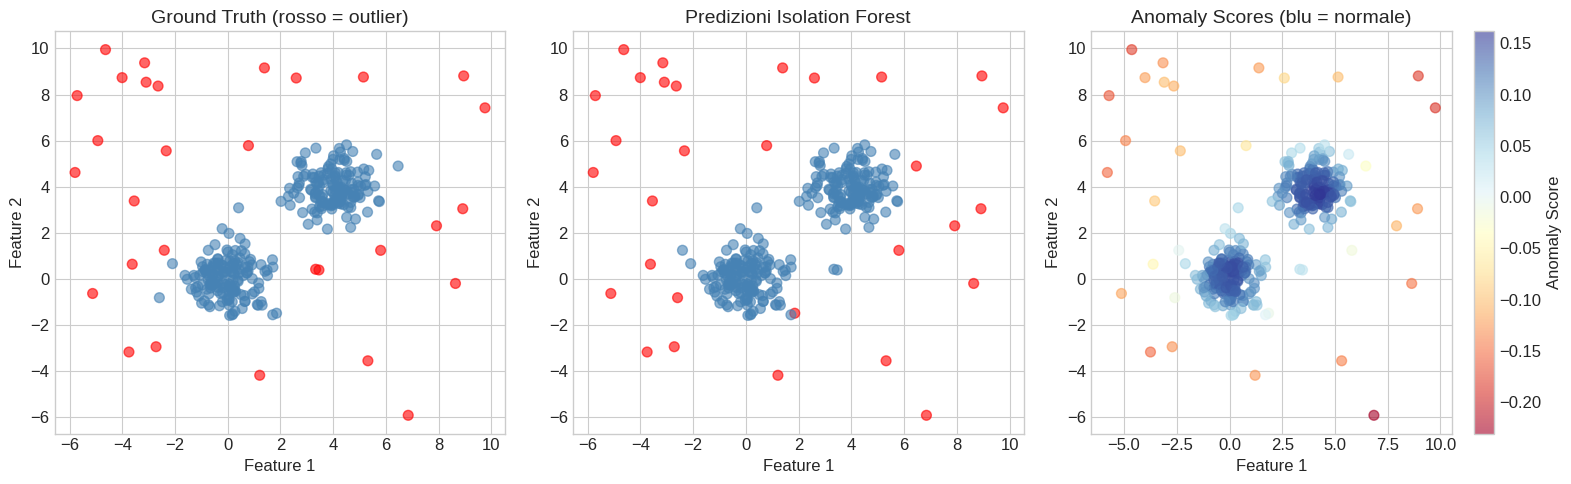

REPORT DI CLASSIFICAZIONE
               precision    recall  f1-score   support

Anomalia (-1)       0.90      0.90      0.90        30
  Normale (1)       0.99      0.99      0.99       300

     accuracy                           0.98       330
    macro avg       0.95      0.95      0.95       330
 weighted avg       0.98      0.98      0.98       330


Matrice di Confusione:
[[ 27   3]
 [  3 297]]


In [15]:
# SEZIONE 4.1: Isolation Forest
# Questa sezione e completamente incapsulata

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Generazione dati con outlier
np.random.seed(42)

# Dati normali: 2 cluster
n_normal = 300
X_normal_1 = np.random.randn(n_normal // 2, 2) * 0.8 + np.array([0, 0])
X_normal_2 = np.random.randn(n_normal // 2, 2) * 0.8 + np.array([4, 4])
X_normal = np.vstack([X_normal_1, X_normal_2])

# Outlier sparsi - generati lontano dai cluster per evitare sovrapposizioni
n_outliers = 30
# Generiamo in un range piu ampio e filtriamo quelli troppo vicini ai centri
outlier_candidates = np.random.uniform(low=-6, high=10, size=(n_outliers * 3, 2))
# Distanza minima dai centri dei cluster [0,0] e [4,4]
dist_c1 = np.linalg.norm(outlier_candidates - np.array([0, 0]), axis=1)
dist_c2 = np.linalg.norm(outlier_candidates - np.array([4, 4]), axis=1)
far_enough = (dist_c1 > 2.5) & (dist_c2 > 2.5)
X_outliers = outlier_candidates[far_enough][:n_outliers]

# Dataset completo
X_if = np.vstack([X_normal, X_outliers])
y_true_if = np.array([1] * n_normal + [-1] * n_outliers)  # 1 = normale, -1 = anomalia

# Standardizzazione
scaler_if = StandardScaler()
X_if_scaled = scaler_if.fit_transform(X_if)

# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,           # Numero di alberi
    contamination=n_outliers/len(X_if),  # Proporzione effettiva di outlier nel dataset
    max_samples='auto',         # Campioni per albero
    random_state=42,
    n_jobs=-1
)

# Fit e predict
y_pred_if = iso_forest.fit_predict(X_if_scaled)
scores_if = iso_forest.decision_function(X_if_scaled)

# Visualizzazione
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Dati originali con ground truth
colors_true = ['steelblue' if y == 1 else 'red' for y in y_true_if]
axes[0].scatter(X_if[:, 0], X_if[:, 1], c=colors_true, alpha=0.6, s=50)
axes[0].set_title('Ground Truth (rosso = outlier)', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Predizioni Isolation Forest
colors_pred = ['steelblue' if y == 1 else 'red' for y in y_pred_if]
axes[1].scatter(X_if[:, 0], X_if[:, 1], c=colors_pred, alpha=0.6, s=50)
axes[1].set_title('Predizioni Isolation Forest', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# Anomaly scores
scatter = axes[2].scatter(X_if[:, 0], X_if[:, 1], c=scores_if, cmap='RdYlBu', alpha=0.6, s=50)
plt.colorbar(scatter, ax=axes[2], label='Anomaly Score')
axes[2].set_title('Anomaly Scores (blu = normale)', fontsize=14)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Metriche
from sklearn.metrics import classification_report, confusion_matrix

print("=" * 50)
print("REPORT DI CLASSIFICAZIONE")
print("=" * 50)
print(classification_report(y_true_if, y_pred_if, target_names=['Anomalia (-1)', 'Normale (1)']))

print("\nMatrice di Confusione:")
print(confusion_matrix(y_true_if, y_pred_if))

### 4.2 Local Outlier Factor (LOF)

**LOF** e un algoritmo basato sulla densita che confronta la densita locale di un punto con quella dei suoi vicini. Un punto con densita molto inferiore ai vicini e un outlier.

$$LOF(x) = \frac{\text{media densita vicini di } x}{\text{densita di } x}$$

- LOF $\approx 1$: densita simile ai vicini (normale)
- LOF $>> 1$: densita molto inferiore ai vicini (outlier)

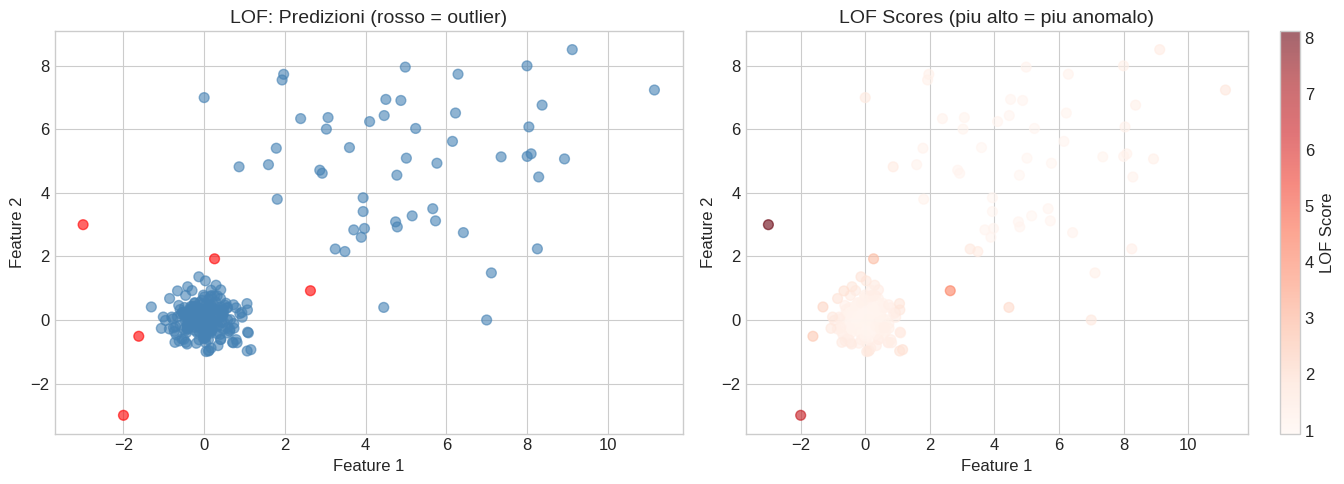

Outlier rilevati: 5
Top 5 punti con LOF piu alto: [250 253 215 104 131]


In [16]:
# SEZIONE 4.2: Local Outlier Factor
# Questa sezione e completamente incapsulata

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Generazione dati con cluster di densita diversa
np.random.seed(42)

# Cluster denso
cluster_dense = np.random.randn(200, 2) * 0.5 + np.array([0, 0])
# Cluster sparso
cluster_sparse = np.random.randn(50, 2) * 2 + np.array([5, 5])
# Outlier
outliers_lof = np.array([[-3, 3], [7, 0], [0, 7], [-2, -3], [8, 8]])

X_lof = np.vstack([cluster_dense, cluster_sparse, outliers_lof])
y_true_lof = np.array([1] * 250 + [-1] * 5)

# Local Outlier Factor
# Calcoliamo la contaminazione effettiva dal dataset
contamination_actual = len(outliers_lof) / len(X_lof)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination_actual,
    novelty=False  # Per outlier detection (non novelty detection)
)

y_pred_lof = lof.fit_predict(X_lof)
lof_scores = -lof.negative_outlier_factor_  # Convertiamo in positivo

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predizioni
colors_lof = ['steelblue' if y == 1 else 'red' for y in y_pred_lof]
axes[0].scatter(X_lof[:, 0], X_lof[:, 1], c=colors_lof, alpha=0.6, s=50)
axes[0].set_title('LOF: Predizioni (rosso = outlier)', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# LOF scores
scatter = axes[1].scatter(X_lof[:, 0], X_lof[:, 1], c=lof_scores, cmap='Reds', alpha=0.6, s=50)
plt.colorbar(scatter, ax=axes[1], label='LOF Score')
axes[1].set_title('LOF Scores (piu alto = piu anomalo)', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print(f"Outlier rilevati: {sum(y_pred_lof == -1)}")
print(f"Top 5 punti con LOF piu alto: {np.argsort(lof_scores)[-5:][::-1]}")

**Confronto Isolation Forest vs LOF**

| Caratteristica | Isolation Forest | LOF |
|----------------|-----------------|-----|
| **Approccio** | Isolamento | Densita locale |
| **Complessita** | O(n log n) | O(n^2) |
| **Scalabilita** | Eccellente | Moderata |
| **Cluster multidensita** | Difficolta | Gestisce bene |
| **Alta dimensionalita** | Funziona bene | Soffre |
| **Interpretabilita** | Media | Alta (LOF score) |